In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import glob
import os
import sys
import logging
from itertools import chain

import requests
from tqdm import tqdm, tqdm_notebook, tnrange
#tqdm = tqdm_notebook

import vigra
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from numba import jit

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease.dvid import *
from neuclease.util import Timer
from neuclease.misc import find_best_plane

In [6]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url

In [7]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

In [8]:
cd /nrs/flyem/bergs/complete-ffn-agglo/

/nrs/flyem/bergs/complete-ffn-agglo


In [9]:
!uname -n

h10u12.int.janelia.org


In [10]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [11]:
sc

<SparkContext master=spark://h02u03:7077 appName=PySparkShell>

### Hostgraph URLS

In [12]:
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
print("Cluster:")
print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=44106114&submit_time=1532486124
Cluster:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=44106116&submit_time=1532486137


### UUIDs

In [13]:
# The starting agglo
initial_agglo = DvidInstanceInfo('emdata3:8900', 'ac901', 'segmentation')

# The uuid used when loading the neo4j instance (for 'important bodies')
neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# The last supervoxel splits: One past the neo4j node
analysis_node = DvidInstanceInfo('emdata3:8900', '662e', 'segmentation')

# We won't be using this...
current_master = DvidInstanceInfo('emdata3:8900', 'f545', 'segmentation')

### Load neo4j-defined important bodies; append final splits

In [14]:
# This list was generated from node 52f9
important_bodies_path = '/nrs/flyem/bergs/complete-ffn-agglo/bodies-0.5-from-neuprint-52f9.csv'
important_bodies = pd.read_csv(important_bodies_path, header=0, usecols=['bodyId'], dtype=np.uint64)['bodyId']
important_bodies = set(important_bodies)

# Read last set of new bodies (from analysis node, after neo4j was loaded).
msgs = read_kafka_messages(analysis_node, 'split', 'leaf-only')
final_new_bodies = set(chain(*((msg['Target'], msg['NewLabel']) for msg in msgs)))

# Append final set
important_bodies |= final_new_bodies

Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / 662e / segmentation
Reading 166737 kafka messages took 7.111119747161865 seconds


### Load pre-filtered table

In [12]:
# id_a, id_b -- the two supervoxel IDs
# xa, ya, za -- point from which segmentation of 'a' was started, 8 nm coordinates
# xb, yb, zb -- point from which segmentation of 'b' was started, 8 nm coordinates
# caa, cab, cba, cbb -- cXY means: fraction of voxels from the original segment Y recovered when seeding from X
# iou -- Jaccard index of the two local segmentations
# da, db -- dX means: fraction of voxels that changed value from >0.8 to <0.5 when segmenting & seeding from X;
#                     the higher this value is, the more "internally inconsistent" the segmentation resolution
#                     potentially is; higher thresholds for iou, cXY might be warranted


# This table uses SV ids from the 'analysis node', and includes only
# edges that mention at least one "important" supervoxel
with Timer("Loading edge table"):
    combined_table = np.load('combined-filtered-table.npy')
    combined_df = pd.DataFrame(combined_table)
print(f"Loaded {len(combined_df) / 1e6:.1f}M edges")
print(f"Memory usage: {combined_df.memory_usage().sum() / 1e9:.1f} GB")

Loading edge table...
Loading edge table took 0:02:27.953363
Loaded 755.5M edges
Memory usage: 64.2 GB


In [13]:
%time all_svs = pd.concat((combined_df['id_a'], combined_df['id_b']), ignore_index=True)

CPU times: user 5.07 s, sys: 5.15 s, total: 10.2 s
Wall time: 321 ms


In [14]:
%%time 
sv_counts = all_svs.value_counts()
unimportant_sv_counts = sv_counts[~sv_counts.index.isin(important_bodies)]
print((unimportant_sv_counts == 1).sum())

23034587
CPU times: user 3min 31s, sys: 47.9 s, total: 4min 19s
Wall time: 2min 42s


### One-hop only?

In [15]:
len(important_bodies)

509238

In [16]:
def chunkify_table(table, approx_chunk_len):
    approx_chunk_len = int(approx_chunk_len)
    total_len = len(table)
    num_chunks = max(1, total_len // approx_chunk_len)
    chunk_len = total_len // num_chunks

    partitions = list(range(0, chunk_len*num_chunks, chunk_len))
    if partitions[-1] < total_len:
        partitions.append( total_len )

    for (start, stop) in zip(partitions[:-1], partitions[1:]):
        yield table[start:stop]

#### Cache chunks to disk

In [17]:
# os.makedirs('combined-filtered-chunks', exist_ok=True)
# num_chunks = len(combined_table)//10**6
# for i, table_chunk in tqdm(enumerate(chunkify_table(combined_table, 10**6)), total=num_chunks):
#     np.save(f'combined-filtered-chunks/chunk-{i:05}.npy', table_chunk)

In [18]:
def append_importances(i):
    chunk_path = f'/nrs/flyem/bergs/complete-ffn-agglo/combined-filtered-chunks/chunk-{i:05}.npy'
    df = pd.DataFrame(np.load(chunk_path))
    df['important_a'] = df['body_a'].isin(important_bodies)
    df['important_b'] = df['body_b'].isin(important_bodies)
    return df.to_records(index=False)

In [19]:
#num_chunks = len(combined_table)//10**6
num_chunks = 755
%time table_chunks = sc.parallelize(range(num_chunks)).map(append_importances).collect()

CPU times: user 31.6 s, sys: 41.8 s, total: 1min 13s
Wall time: 2min 58s


In [20]:
#combined_table = np.concatenate(table_chunks)

In [20]:
%time onehop_chunks = [chunk[chunk['important_a'] & chunk['important_b']] for chunk in tqdm(table_chunks)]

100%|██████████| 755/755 [00:18<00:00, 41.93it/s]

CPU times: user 13.7 s, sys: 4.43 s, total: 18.1 s
Wall time: 18 s


In [21]:
sum(map(len, onehop_chunks))

162618536

In [22]:
@jit(nopython=True)
def calc_score_32nm(caa, cab, cba, cbb, iou, da, db):
    if (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        return 0.0 + (1.0 - iou)
    elif (caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou > 0.4):
        return 5.0 + (1.0 - iou)
    elif (caa > 0.8 and cab > 0.8):
        return 11.0 + (1.0 - min(caa, cab))
    else:
        return 11.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_16nm(caa, cab, cba, cbb, iou, da, db):
    if ( caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6
    and iou > 0.8 and (da <= 0.02 or db <= 0.02)):
        # This is probably wrong...
        return 3.0 + (1.0 - iou)

# This is the original function...
#         if d.id_b = 0 or e.id_b = 0:
#             if b.class == 6 and c.class == 6:
#                 return 1.0 + (1.0 - iou)
#             else:
#                 return 2.0 + (1.0 - iou)
#         else:
#             if b.class = 6 and c.class = 6:
#                 return 3.0 + (1.0 - iou)
#             else:
#                 return 4.0 + (1.0 - iou)
    else:
        if caa >= 0.6 and cab >= 0.6 and cba >= 0.6 and cbb >= 0.6 and iou >= 0.4:
            # This is probably wrong...
            return 8.0 + (1.0 - iou)

# This is the original function...
#             if d.id_b = 0 or e.id_b = 0:
#                 if b.class = 6 and c.class = 6:
#                     return 6.0 + (1.0 - iou),
#                 else:
#                     return 7.0 + (1.0 - iou)
#             else:
#                 if b.class = 6 and c.class = 6:
#                     return 8.0 + (1.0 - iou)
#                 else:
#                     return 9.0 + (1.0 - iou)
        else:
            if caa > 0.9 and cab > 0.9:
                return 12.0 + (1.0 - min(caa, cab))
            else:
                return 12.0 + (1.0 - min(cba, cbb))


@jit(nopython=True)
def calc_score_8nm(caa, cab, cba, cbb, iou, da, db):
    return 10.0 + (1.0 - iou)


@jit(nopython=True)
def calc_score(resolution, caa, cab, cba, cbb, iou, da, db):
    if resolution == 32:
        return calc_score_32nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 16:
        return calc_score_16nm(caa, cab, cba, cbb, iou, da, db)
    if resolution == 8:
        return calc_score_8nm(caa, cab, cba, cbb, iou, da, db)
    return np.inf
        
@jit(nopython=True)
def calc_agglo_scores(table):
    scores = np.empty(len(table), np.float32)
    for i in range(len(table)):
        resolution = table['resolution'][i]
        caa = table['caa'][i]
        cab = table['cab'][i]
        cba = table['cba'][i]
        cbb = table['cbb'][i]
        iou = table['iou'][i]
        da = table['da'][i]
        db = table['db'][i]
        scores[i] = calc_score(resolution, caa, cab, cba, cbb, iou, da, db)
    return scores

In [ ]:
#@jit
#def calc_speculative_scores(table):
    

In [23]:
%time onehop_scores = list(map(calc_scores, onehop_chunks))

CPU times: user 2.46 s, sys: 668 ms, total: 3.13 s
Wall time: 3.12 s


In [24]:
all_onehop_scores = np.concatenate(onehop_scores)

In [25]:
%time onehop_table = np.concatenate(onehop_chunks)

CPU times: user 3min, sys: 1min 6s, total: 4min 7s
Wall time: 8.85 s


In [26]:
onehop_table.shape

(162618536,)

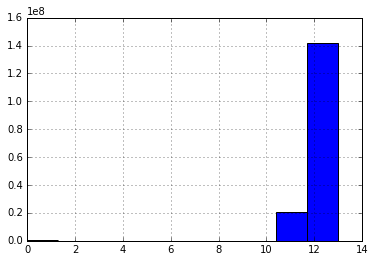

In [27]:
onehop_df = pd.DataFrame(onehop_table)
onehop_df['score'] = all_onehop_scores
onehop_df['score'].hist()

In [28]:
%time body_a_stats = onehop_df.groupby('body_a').agg({'score': ['min', 'idxmin', 'size']})
body_a_stats.columns = ['min_score', 'min_index', 'edge_count']

CPU times: user 1min 41s, sys: 14.8 s, total: 1min 56s
Wall time: 1min 24s


In [29]:
%time body_b_stats = onehop_df.groupby('body_b').agg({'score': ['min', 'idxmin', 'size']})
body_b_stats.columns = ['min_score', 'min_index', 'edge_count']

CPU times: user 1min 11s, sys: 7.17 s, total: 1min 18s
Wall time: 1min 4s


In [30]:
%%time
merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer', left_index=True, right_index=True,
                                                      suffixes=['_a', '_b'])

CPU times: user 85.1 ms, sys: 17 ms, total: 102 ms
Wall time: 101 ms


In [43]:
%%time

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

body_stats = pd.DataFrame({'min_score': min_scores,
                           'min_index': min_index,
                           'edge_count': edge_counts,
                           'side': sides})

CPU times: user 1.45 s, sys: 565 ms, total: 2.02 s
Wall time: 111 ms


In [44]:
%%time
onehop_df['is_favorite_of_a'] = False
onehop_df['is_favorite_of_b'] = False

body_a_favorite_edges = body_stats.query("side == 'a'")['min_index'].astype(np.int64)
body_b_favorite_edges = body_stats.query("side == 'b'")['min_index'].astype(np.int64)

onehop_df.loc[body_a_favorite_edges, 'is_favorite_of_a'] = True
onehop_df.loc[body_b_favorite_edges, 'is_favorite_of_b'] = True

CPU times: user 10.2 s, sys: 3.82 s, total: 14.1 s
Wall time: 1.85 s


In [47]:
#body_stats.isnull().sum()
#body_stats[:10]
#min_index.isnull().sum()
print(onehop_df['is_favorite_of_a'].sum() + onehop_df['is_favorite_of_b'].sum())
print((onehop_df['is_favorite_of_a'] & onehop_df['is_favorite_of_b']).sum())

508760
57517


In [50]:
len(important_bodies) - 508760

478

In [ ]:
body_stats['edge_count'].argmax()

In [87]:
body_stats.loc[950880008]

edge_count         181680
min_index     1.04102e+08
min_score         3.03052
side                    a
Name: 950880008, dtype: object

In [ ]:
body_stats['edge_count'][body_stats['edge_count'] > 50000].hist()

In [ ]:
body_stats['min_score'].hist()

In [ ]:
s = body_stats['min_score']
s[(s > 10) & (s < 11)].hist()

In [ ]:
(s > 12).sum()

In [108]:
min_edges = body_stats.drop(0).query('side != "x"')['min_index'].astype(np.int64)
np.random.seed(0)
random_edges = np.random.choice(min_edges.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-20180725.json')

In [110]:
!uname -n

h10u12.int.janelia.org


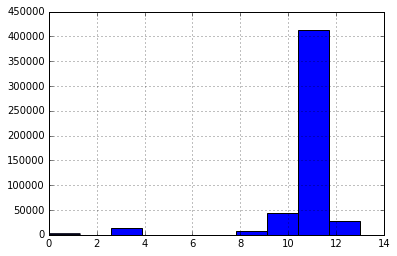

In [52]:
body_stats['min_score'].hist()

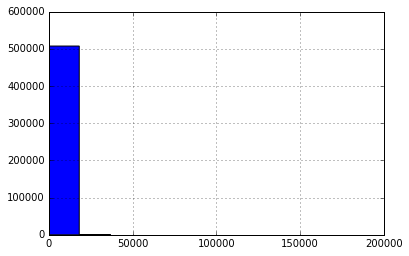

In [51]:
ec = body_stats['edge_count']
display(ec.hist())

508836 bodies with fewer than 50000 edges
0.999785831475


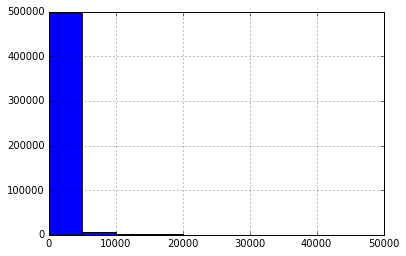

In [53]:
ec = body_stats['edge_count']

cutoff = 50000
print((ec < cutoff).sum(), f'bodies with fewer than {cutoff} edges')
print((ec < cutoff).sum() / len(ec))
display(ec[ec < cutoff].hist())

504394 bodies with fewer than 10000 edges
0.991057972865


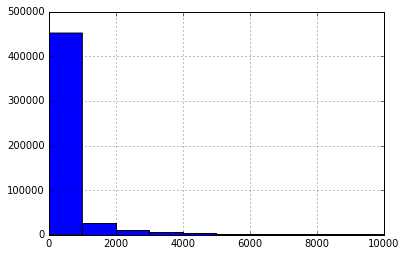

In [101]:
ec = body_stats['edge_count']

cutoff = 10000
print((ec < cutoff).sum(), f'bodies with fewer than {cutoff} edges')
print((ec < cutoff).sum() / len(ec))
display(ec[ec < cutoff].hist())

451903 bodies with fewer than 1000 edges
0.88792109167


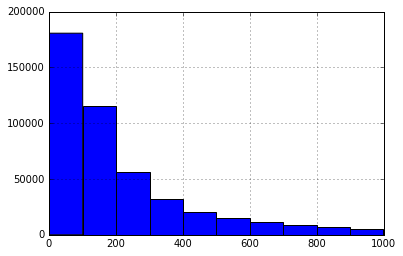

In [55]:
ec = body_stats['edge_count']

cutoff = 1000
print((ec < cutoff).sum(), f'bodies with fewer than {cutoff} edges')
print((ec < cutoff).sum() / len(ec))
display(ec[ec < cutoff].hist())

254751 bodies with fewer than 155 edges
0.500547210406


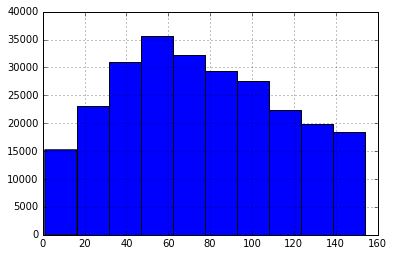

In [56]:
ec = body_stats['edge_count']

cutoff = 155
print((ec < cutoff).sum(), f'bodies with fewer than {cutoff} edges')
print((ec < cutoff).sum() / len(ec))
display(ec[ec < cutoff].hist())

In [57]:
onehop_df.shape

(162618536, 23)

In [58]:
spec1 = np.load('/nrs/flyem/bergs/final-agglo/speculative-iterations/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy')

In [59]:
spec1.shape

(75446740,)

In [60]:
spec1 = pd.DataFrame(spec1)

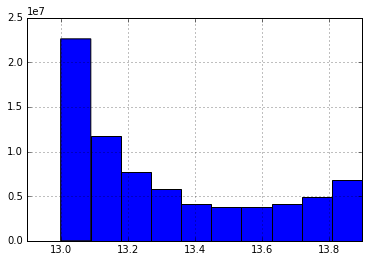

In [62]:
spec1['score'].hist()

In [63]:
spec1.iloc[:10]

,id_a,id_b,xa,ya,za,xb,yb,zb,score
0,109025907,140060777,23837,20286,1763,23834,20302,1776,13.0
1,109025923,109025907,23841,20291,1766,23837,20286,1763,13.0
2,109707975,110049207,23955,21390,1669,23954,21396,1672,13.0
3,110049207,109707975,23954,21396,1672,23955,21390,1669,13.0
4,112380390,143415169,18277,24774,1789,18268,24767,1781,13.0
5,138636189,138636194,17836,18720,2184,17816,18714,2192,13.0
6,138636194,138636189,17816,18714,2192,17836,18720,2184,13.0
7,139378906,139720023,23717,19651,1888,23724,19652,1890,13.0
8,139720022,139378906,23722,19652,1890,23717,19651,1888,13.0
9,139720023,139720022,23724,19652,1890,23722,19652,1890,13.0


In [69]:
%time twohop_table = np.concatenate(table_chunks)

CPU times: user 8min 37s, sys: 3min 25s, total: 12min 3s
Wall time: 23.5 s


In [70]:
twohop_scores = calc_scores(twohop_table)

In [71]:
%time twohop_df = pd.DataFrame.from_records(twohop_table)

CPU times: user 2min 40s, sys: 3min 5s, total: 5min 46s
Wall time: 3min 26s


In [72]:
twohop_df['score'] = twohop_scores

In [81]:
%time twohop_subset_df = twohop_df.query('body_a % 20 == 0 or body_b % 20 == 0').copy()

CPU times: user 1min 17s, sys: 1min 3s, total: 2min 20s
Wall time: 1min 15s


In [82]:
twohop_subset_df.shape

(71935320, 21)

In [88]:
del twohop_table
del twohop_df
del twohop_scores

In [96]:
%%time
body_a_stats = twohop_subset_df.groupby('body_a').agg({'score': ['min']})
body_a_stats.columns = ['min_score']

body_b_stats = twohop_subset_df.groupby('body_b').agg({'score': ['min']})
body_b_stats.columns = ['min_score']

CPU times: user 29.9 s, sys: 6.35 s, total: 36.3 s
Wall time: 17.8 s


In [90]:
%%time
merged_body_stats = pd.DataFrame(body_a_stats).merge(body_b_stats, 'outer', left_index=True, right_index=True,
                                                      suffixes=['_a', '_b'])

CPU times: user 2.83 s, sys: 899 ms, total: 3.73 s
Wall time: 765 ms


In [91]:
%%time

# Combine scores/indexes and edge counts, and record which side of the edge the score came from.
min_scores = merged_body_stats[['min_score_a', 'min_score_b']].min(axis=1)
edge_counts = merged_body_stats[['edge_count_a', 'edge_count_b']].sum(axis=1).astype(np.uint32)

min_index = merged_body_stats['min_index_b'].copy()
pos_a = merged_body_stats['min_score_a'] < merged_body_stats['min_score_b']
min_index.loc[pos_a] = merged_body_stats['min_index_a']

sides = pd.Series('b', index=merged_body_stats.index)
sides.loc[pos_a] = 'a'
sides.loc[min_index.isnull()] = 'x'
sides = sides.astype('category')

twohop_body_stats = pd.DataFrame({'min_score': min_scores,
                                  'min_index': min_index,
                                  'edge_count': edge_counts,
                                  'side': sides})

CPU times: user 15.5 s, sys: 4.27 s, total: 19.8 s
Wall time: 1.35 s


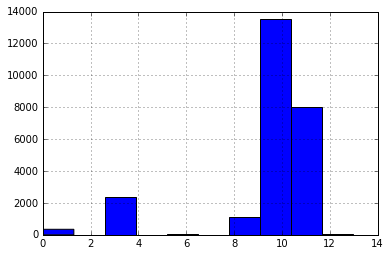

In [100]:
q = '(index in @important_bodies) and (index % 20 == 0)'
twohop_body_stats.query(q)['min_score'].hist()

In [95]:
twohop_subset_df.iloc[:10].values.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

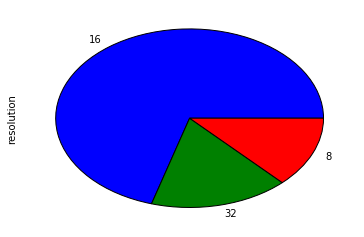

In [112]:
onehop_df['resolution'].value_counts().plot(kind='pie')

In [114]:
onehop_df['resolution'].value_counts() / len(onehop_df['resolution'])

16    0.704103
32    0.167573
8     0.128324
Name: resolution, dtype: float64

In [115]:
%%time
best_edges_index = body_stats.drop(0).query('side != "x"')['min_index'].astype(np.int64)
best_onehop_df = onehop_df.loc[best_edges_index]

CPU times: user 28.2 s, sys: 4.47 s, total: 32.7 s
Wall time: 11.2 s


In [116]:
best_onehop_df.shape

(508759, 23)

8     0.897505
16    0.056080
32    0.046415
Name: resolution, dtype: float64

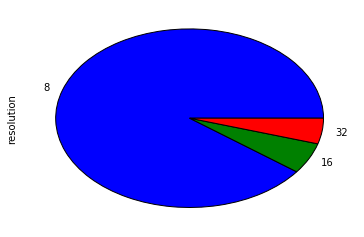

In [119]:
resolution_fractions = best_onehop_df['resolution'].value_counts() / len(best_onehop_df['resolution'])
display(resolution_fractions)
resolution_fractions.plot(kind='pie')

In [125]:
SMALL_BODY_CUTOFF = 155
small_body_stats = body_stats.drop(0).query('side != "x" and edge_count <= @SMALL_BODY_CUTOFF')
small_best_edges_index = small_body_stats['min_index'].astype(np.int64)

np.random.seed(0)
random_edges = np.random.choice(small_best_edges_index.values, 100, False)
assignment_table = onehop_df.loc[random_edges]

from neuclease.merge_table import generate_focused_assignment
_ = generate_focused_assignment(assignment_table, 'test-assignment-SMALL-BODIES-20180725.json')


20335

In [126]:
spec1.iloc[:10]

,id_a,id_b,xa,ya,za,xb,yb,zb,score
0,109025907,140060777,23837,20286,1763,23834,20302,1776,13.0
1,109025923,109025907,23841,20291,1766,23837,20286,1763,13.0
2,109707975,110049207,23955,21390,1669,23954,21396,1672,13.0
3,110049207,109707975,23954,21396,1672,23955,21390,1669,13.0
4,112380390,143415169,18277,24774,1789,18268,24767,1781,13.0
5,138636189,138636194,17836,18720,2184,17816,18714,2192,13.0
6,138636194,138636189,17816,18714,2192,17836,18720,2184,13.0
7,139378906,139720023,23717,19651,1888,23724,19652,1890,13.0
8,139720022,139378906,23722,19652,1890,23717,19651,1888,13.0
9,139720023,139720022,23724,19652,1890,23722,19652,1890,13.0


In [137]:
analysis_mapping = fetch_mappings(analysis_node)
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:31.672613
Parsing mapping...
Parsing mapping took 0:00:07.636586


In [141]:
%%time
spec1['body_a'] = analysis_mapper.apply(spec1['id_a'].values, True)
spec1['body_b'] = analysis_mapper.apply(spec1['id_b'].values, True)

CPU times: user 2min 46s, sys: 20 s, total: 3min 6s
Wall time: 2min 47s


In [142]:
spec1_important = spec1.query('(body_a in @important_bodies) and (body_b in @important_bodies)')

In [143]:
spec1_important.shape

(79578, 11)

In [144]:
my_best = set(map(tuple, np.sort(best_onehop_df[['id_a', 'id_b']].values, axis=1)))
spec1_important_edges = set(map(tuple, np.sort(spec1_important[['id_a', 'id_b']].values, axis=1)))

In [145]:
print(f"Did not recover {len(spec1_important_edges - my_best)} out of {len(spec1_important)} of Michal's merges")

Did not recover 60019 out of 79578 of Michal's merges


In [146]:
analysis_node

DvidInstanceInfo(server='emdata3:8900', uuid='662e', instance='segmentation')